# The Kaggle Home Sale Price workflow will have a few key parts:
1. Load data and create a few visualizations and tables
2. Start the data engineering process by replacing or removing null values
3. Continue data engineering by converting all object features into a numerical feature
4. Generate regressor models using the training dataset.  Determine if the model can be simplified by dropping features that have little influence on target modeling
5. Visualize and quantify results
6. Apply the final model to the Test dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import shap

## Load training and test csv files as DataFrames

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## Let's take a look at our target attribute in the training dataset

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

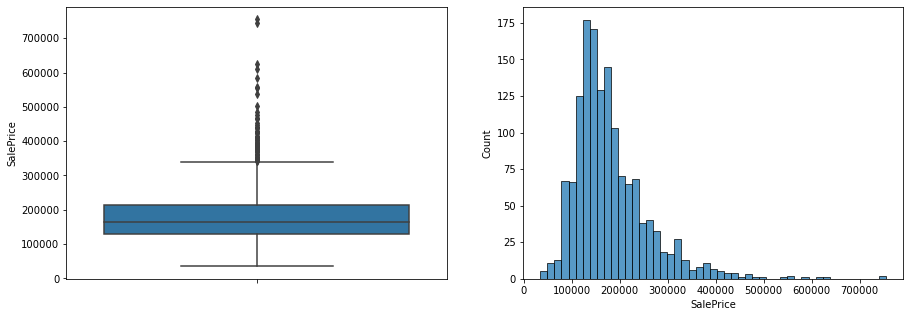

In [3]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data = df, y = 'SalePrice')
plt.subplot(1,2,2)
sns.histplot(data = df, x = 'SalePrice')

> There are some significant outliers that we will likely not be able to model so let's drop them

In [4]:
df['SalePrice'].quantile(.95)

326099.99999999994

In [5]:
df = df[df['SalePrice']<df['SalePrice'].quantile(.95)]

## Let's drop MoSold and YrSold as that information can't be used to predict SalePrice.  We will also drop ID as that will not be used in our predictive analysis

In [6]:
df.drop(['MoSold', 'YrSold', 'Id'], axis = 1, inplace=True)
df_test.drop(['MoSold', 'YrSold', 'Id'], axis = 1, inplace=True)

### Based on the raw data, let's take a look at the Pearson coefficient for SalePrice

In [7]:
df.corr()['SalePrice'].sort_values(ascending=False).drop('SalePrice', axis=0)

OverallQual      0.781060
GrLivArea        0.653331
GarageCars       0.625293
GarageArea       0.602064
FullBath         0.575695
YearBuilt        0.564631
TotalBsmtSF      0.543207
YearRemodAdd     0.541536
1stFlrSF         0.524518
GarageYrBlt      0.507852
TotRmsAbvGrd     0.469249
Fireplaces       0.451581
MasVnrArea       0.342815
OpenPorchSF      0.321616
LotFrontage      0.314642
2ndFlrSF         0.302815
WoodDeckSF       0.301261
BsmtFinSF1       0.276742
HalfBath         0.275381
LotArea          0.249283
BsmtUnfSF        0.234316
BedroomAbvGr     0.197254
BsmtFullBath     0.189854
ScreenPorch      0.112885
PoolArea         0.052033
3SsnPorch        0.047694
BsmtFinSF2       0.014713
MiscVal         -0.011090
BsmtHalfBath    -0.013417
OverallCond     -0.042183
LowQualFinSF    -0.057143
MSSubClass      -0.062689
EnclosedPorch   -0.146864
KitchenAbvGr    -0.147242
Name: SalePrice, dtype: float64

<AxesSubplot:>

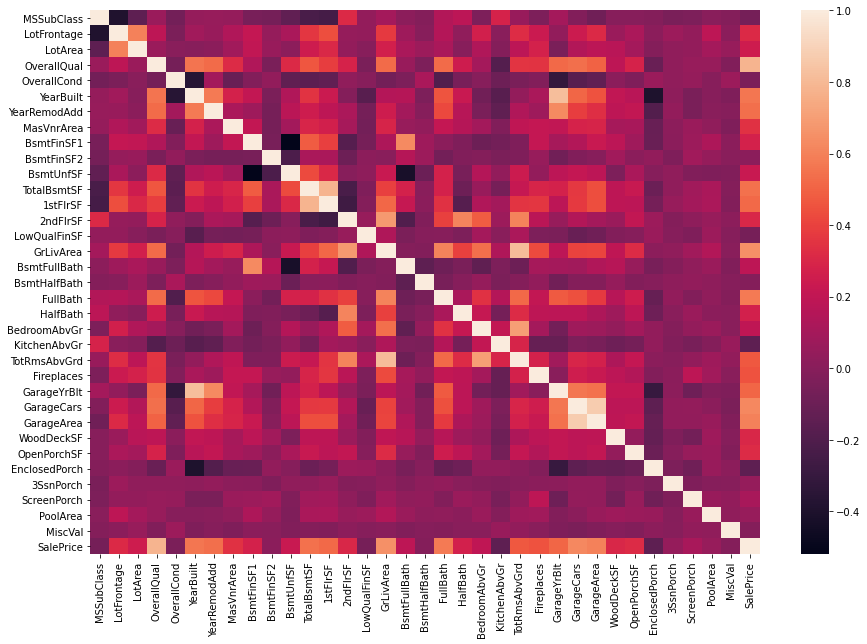

In [8]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr())

### OverallQual, and indication of overall home quality, has a very high correlation coefficient with SalePrice.  However, if we dig a little deeper, we see that OverallQual is categorical with quite a bit of error.  GrLivArea appears to jive well with SalePrice

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

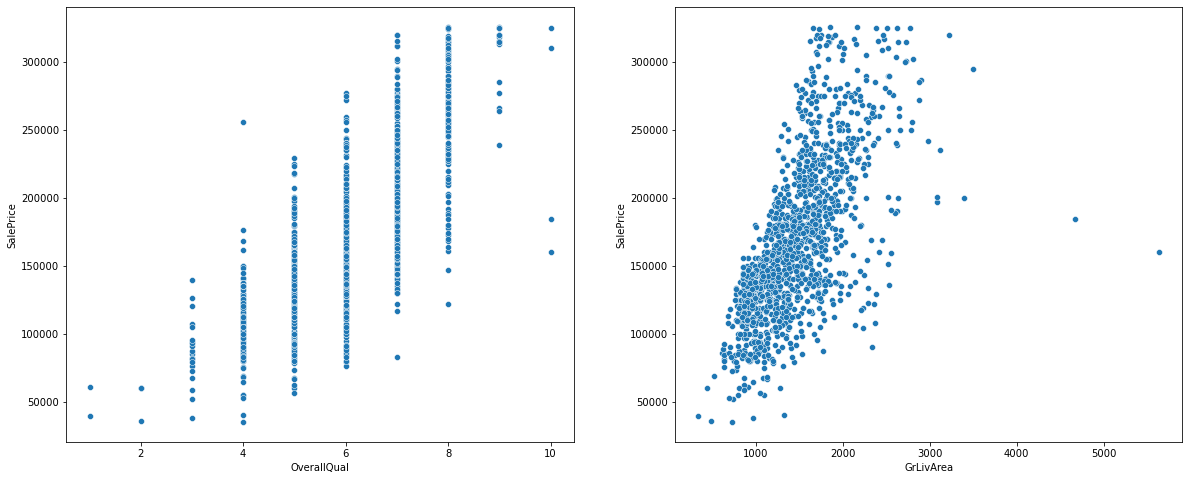

In [9]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.scatterplot(data = df, x = 'OverallQual', y = 'SalePrice')
plt.subplot(1,2,2)
sns.scatterplot(data = df, x = 'GrLivArea', y = 'SalePrice')

## Data Engineering - Removing Null Values

### The data description document states that null values for many of these attributes reflect a lack of said attribute (no garage or no pool) and not due to lack of data collection.  Let's tabulate the extent of null values and convert all of those nulls to 0 where applicable. 

### First, let's address all object/categorical features

In [10]:
df_objects = list(df.select_dtypes(include='object'))
for x in df_objects:
    df[x].fillna('NONE', inplace=True)
    
df_test_objects = list(df_test.select_dtypes(include='object'))
for x in df_test_objects:
    df_test[x].fillna('NONE', inplace=True)

In [11]:
def df_none(x):
    count = len(x.count(axis=1))
    none = pd.DataFrame(x[x=='NONE'].count(), columns = ['Count'])[pd.DataFrame(x[x=='NONE'].count(), columns = ['Count'])['Count']>0]
    none['%_Missing'] = np.round(none/count * 100,1)
    none['Dtype'] = x.dtypes
    none['Item'] = none.index
    return none

In [12]:
df_none(df_test)

,Count,%_Missing,Dtype,Item
MSZoning,4,0.3,object,MSZoning
Alley,1352,92.7,object,Alley
Utilities,2,0.1,object,Utilities
Exterior1st,1,0.1,object,Exterior1st
Exterior2nd,1,0.1,object,Exterior2nd
MasVnrType,16,1.1,object,MasVnrType
BsmtQual,44,3.0,object,BsmtQual
BsmtCond,45,3.1,object,BsmtCond
BsmtExposure,44,3.0,object,BsmtExposure
BsmtFinType1,42,2.9,object,BsmtFinType1


In [13]:
df_none(df)

,Count,%_Missing,Dtype,Item
Alley,1296,93.4,object,Alley
MasVnrType,7,0.5,object,MasVnrType
BsmtQual,37,2.7,object,BsmtQual
BsmtCond,37,2.7,object,BsmtCond
BsmtExposure,38,2.7,object,BsmtExposure
BsmtFinType1,37,2.7,object,BsmtFinType1
BsmtFinType2,38,2.7,object,BsmtFinType2
Electrical,1,0.1,object,Electrical
FireplaceQu,688,49.6,object,FireplaceQu
GarageType,81,5.8,object,GarageType


Text(0.5, 1.0, 'Test')

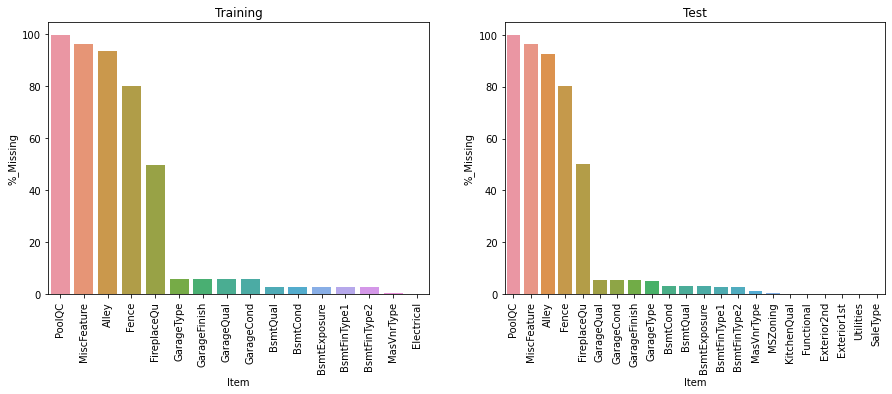

In [14]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.xticks(rotation = '90')
sns.barplot(data = df_none(df), x = 'Item', y = '%_Missing', order = df_none(df).sort_values(by = '%_Missing', ascending = False).Item.values)
plt.title('Training')

plt.subplot(1,2,2)
plt.xticks(rotation = '90')
sns.barplot(data = df_none(df_test), x = 'Item', y = '%_Missing', order = df_none(df_test).sort_values(by = '%_Missing', ascending = False).Item.values)
plt.title('Test')

## PoolQC, Miscfeature, Alley, FirePlaceQu, and Fence are the top 5 attributes missing in both the training and test dataset

<AxesSubplot:xlabel='FireplaceQu', ylabel='count'>

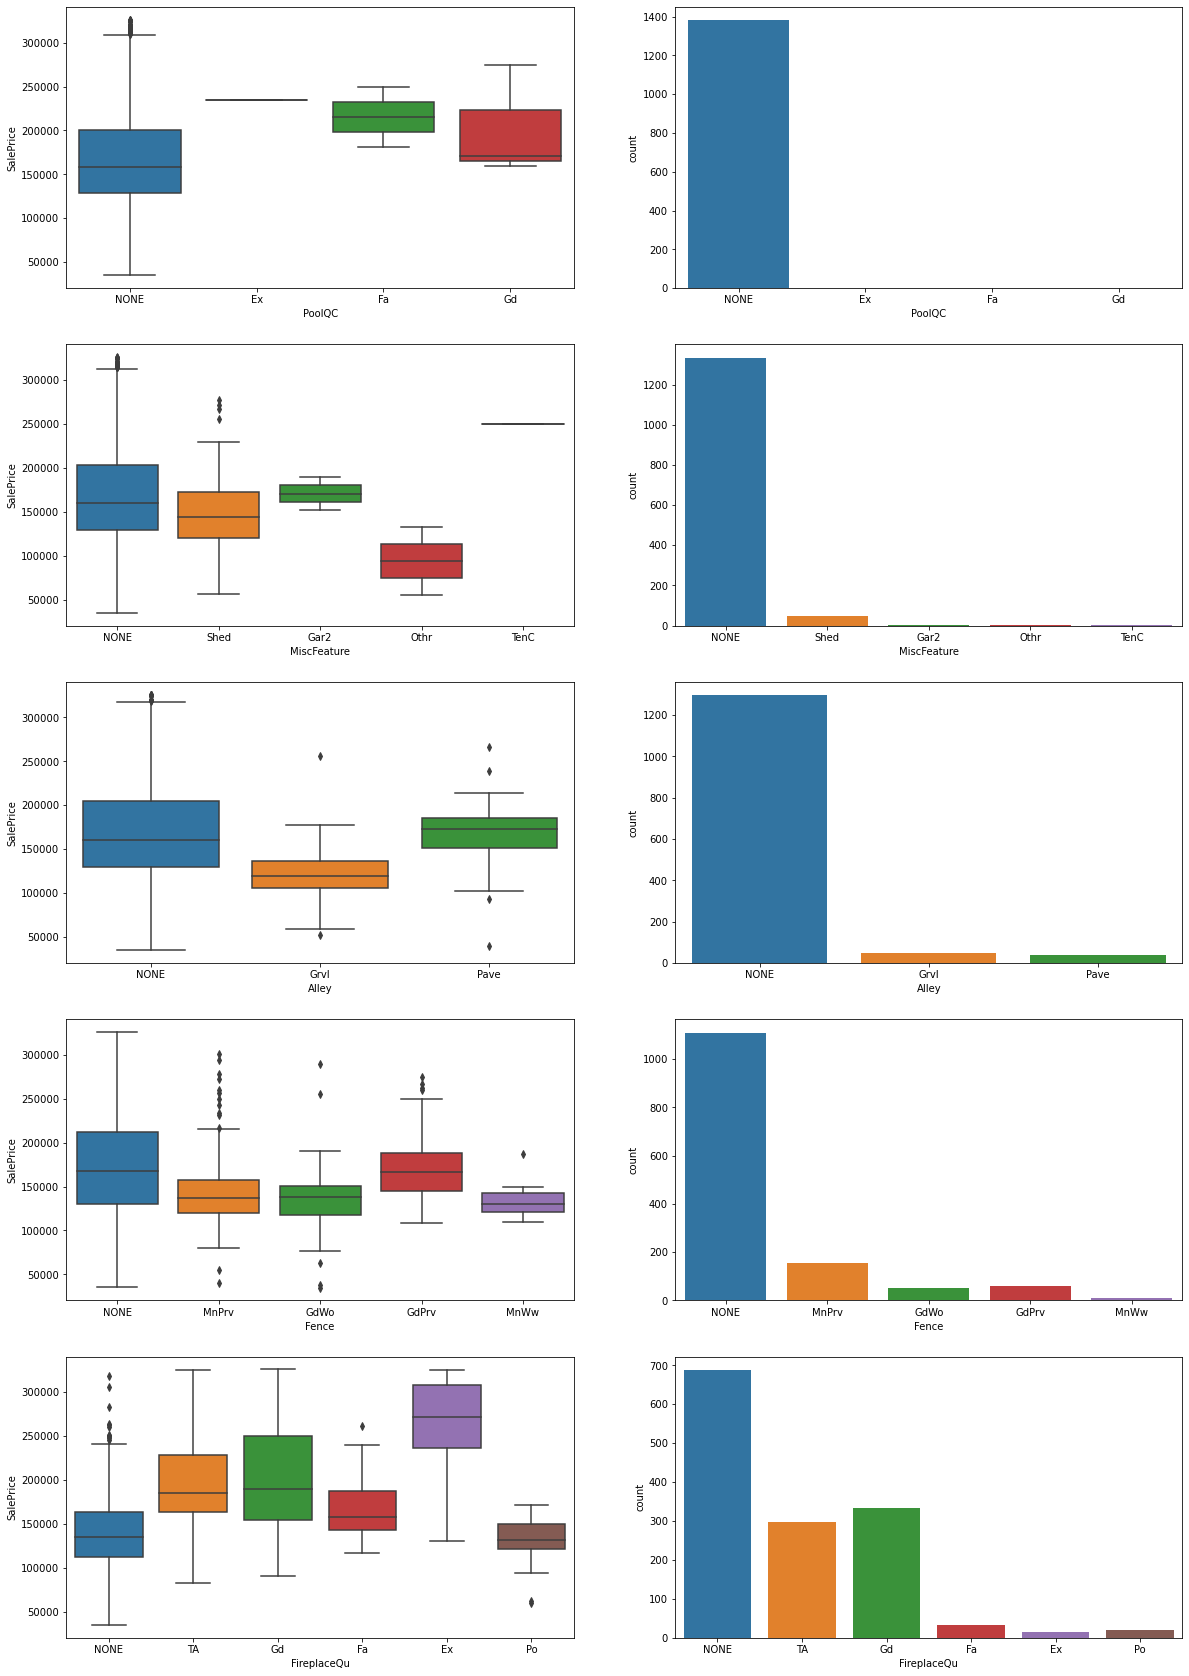

In [15]:
fig, axes = plt.subplots (5,2, figsize=(20,30))

sns.boxplot(ax = axes[0,0], data = df, x='PoolQC', y='SalePrice')
sns.countplot(ax = axes[0,1], data = df, x='PoolQC')
sns.boxplot(ax = axes[1,0], data = df, x='MiscFeature', y='SalePrice')
sns.countplot(ax = axes[1,1], data = df, x='MiscFeature')
sns.boxplot(ax = axes[2,0], data = df, x='Alley', y='SalePrice')
sns.countplot(ax = axes[2,1], data = df, x='Alley')
sns.boxplot(ax = axes[3,0], data = df, x='Fence', y='SalePrice')
sns.countplot(ax = axes[3,1], data = df, x='Fence')
sns.boxplot(ax = axes[4,0], data = df, x='FireplaceQu', y='SalePrice')
sns.countplot(ax = axes[4,1], data = df, x='FireplaceQu')

>PoolQC: Although there aren't a lot of homes with a pool, home value can be tied to the presence of one so we will simplify PoolQC to just indiacte presence of a pool.  

>MiscFeature: There aren't enough homes with a MiscFeature and most that do indicate the presence of a shed which likely will not add much value to our home prediction model (drop).  

>Alley: Most homes don't have Alley access and doesn't appear to correlate with sale price (drop)

>Fence: Fence quality doesn't appear to correlate to sale price (drop).

>FireplaceQu: Fireplace quality shouldn't influence home price too much.  However, the presence of a fireplace might which is captured under Fireplaces 

In [16]:
df.drop(['Alley', 'MiscFeature','Fence', 'FireplaceQu'], axis = 1, inplace=True)
df_test.drop(['Alley', 'MiscFeature', 'Fence', 'FireplaceQu'], axis = 1, inplace=True)

In [17]:
df['Pool'] = df['PoolQC']
df_test['Pool'] = df['PoolQC']
df.drop('PoolQC', axis=1, inplace=True)
df_test.drop('PoolQC', axis=1, inplace=True)

In [18]:
pool = {'Gd':1, 'Fa':1, 'Ex':1, 'NONE':0}
df['Pool'] = df['Pool'].map(pool)
df_test['Pool'] = df_test['Pool'].map(pool)

In [19]:
df_none(df)

,Count,%_Missing,Dtype,Item
MasVnrType,7,0.5,object,MasVnrType
BsmtQual,37,2.7,object,BsmtQual
BsmtCond,37,2.7,object,BsmtCond
BsmtExposure,38,2.7,object,BsmtExposure
BsmtFinType1,37,2.7,object,BsmtFinType1
BsmtFinType2,38,2.7,object,BsmtFinType2
Electrical,1,0.1,object,Electrical
GarageType,81,5.8,object,GarageType
GarageFinish,81,5.8,object,GarageFinish
GarageQual,81,5.8,object,GarageQual


### Most of the remaining missing data is less than 5% of each feature and, in most causes, it should indicate a lack of a feature.  Such features include: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType, GarageFinish, GarageQual, GarageCond.  We will convert these features to numeric values as well as all other object data without nulls

In [20]:
df_lst = list(df.select_dtypes(include = 'object').columns.drop(['MasVnrType', 'Electrical']))
df_test_lst = list(df_test.select_dtypes(include = 'object').columns.drop(['MSZoning', 'Utilities', 'Exterior1st',
                                                                           'Exterior2nd', 'MasVnrType', 'KitchenQual', 
                                                                           'Functional', 'SaleType']))

df[df_lst] = df[df_lst].astype('category')
df_test[df_test_lst] = df_test[df_test_lst].astype('category')

In [21]:
for x in df_lst:
    df[x] = df[x].cat.codes
for x in df_test_lst:
    df_test[x] = df_test[x].cat.codes

In [22]:
df_none(df)

,Count,%_Missing,Dtype,Item
MasVnrType,7,0.5,object,MasVnrType
Electrical,1,0.1,object,Electrical


### MasVnrType can be dropped as it is already captured under the Exterior1st and Exterior2nd features

In [23]:
df.drop('MasVnrType', axis=1, inplace=True)
df_test.drop('MasVnrType', axis=1, inplace=True)

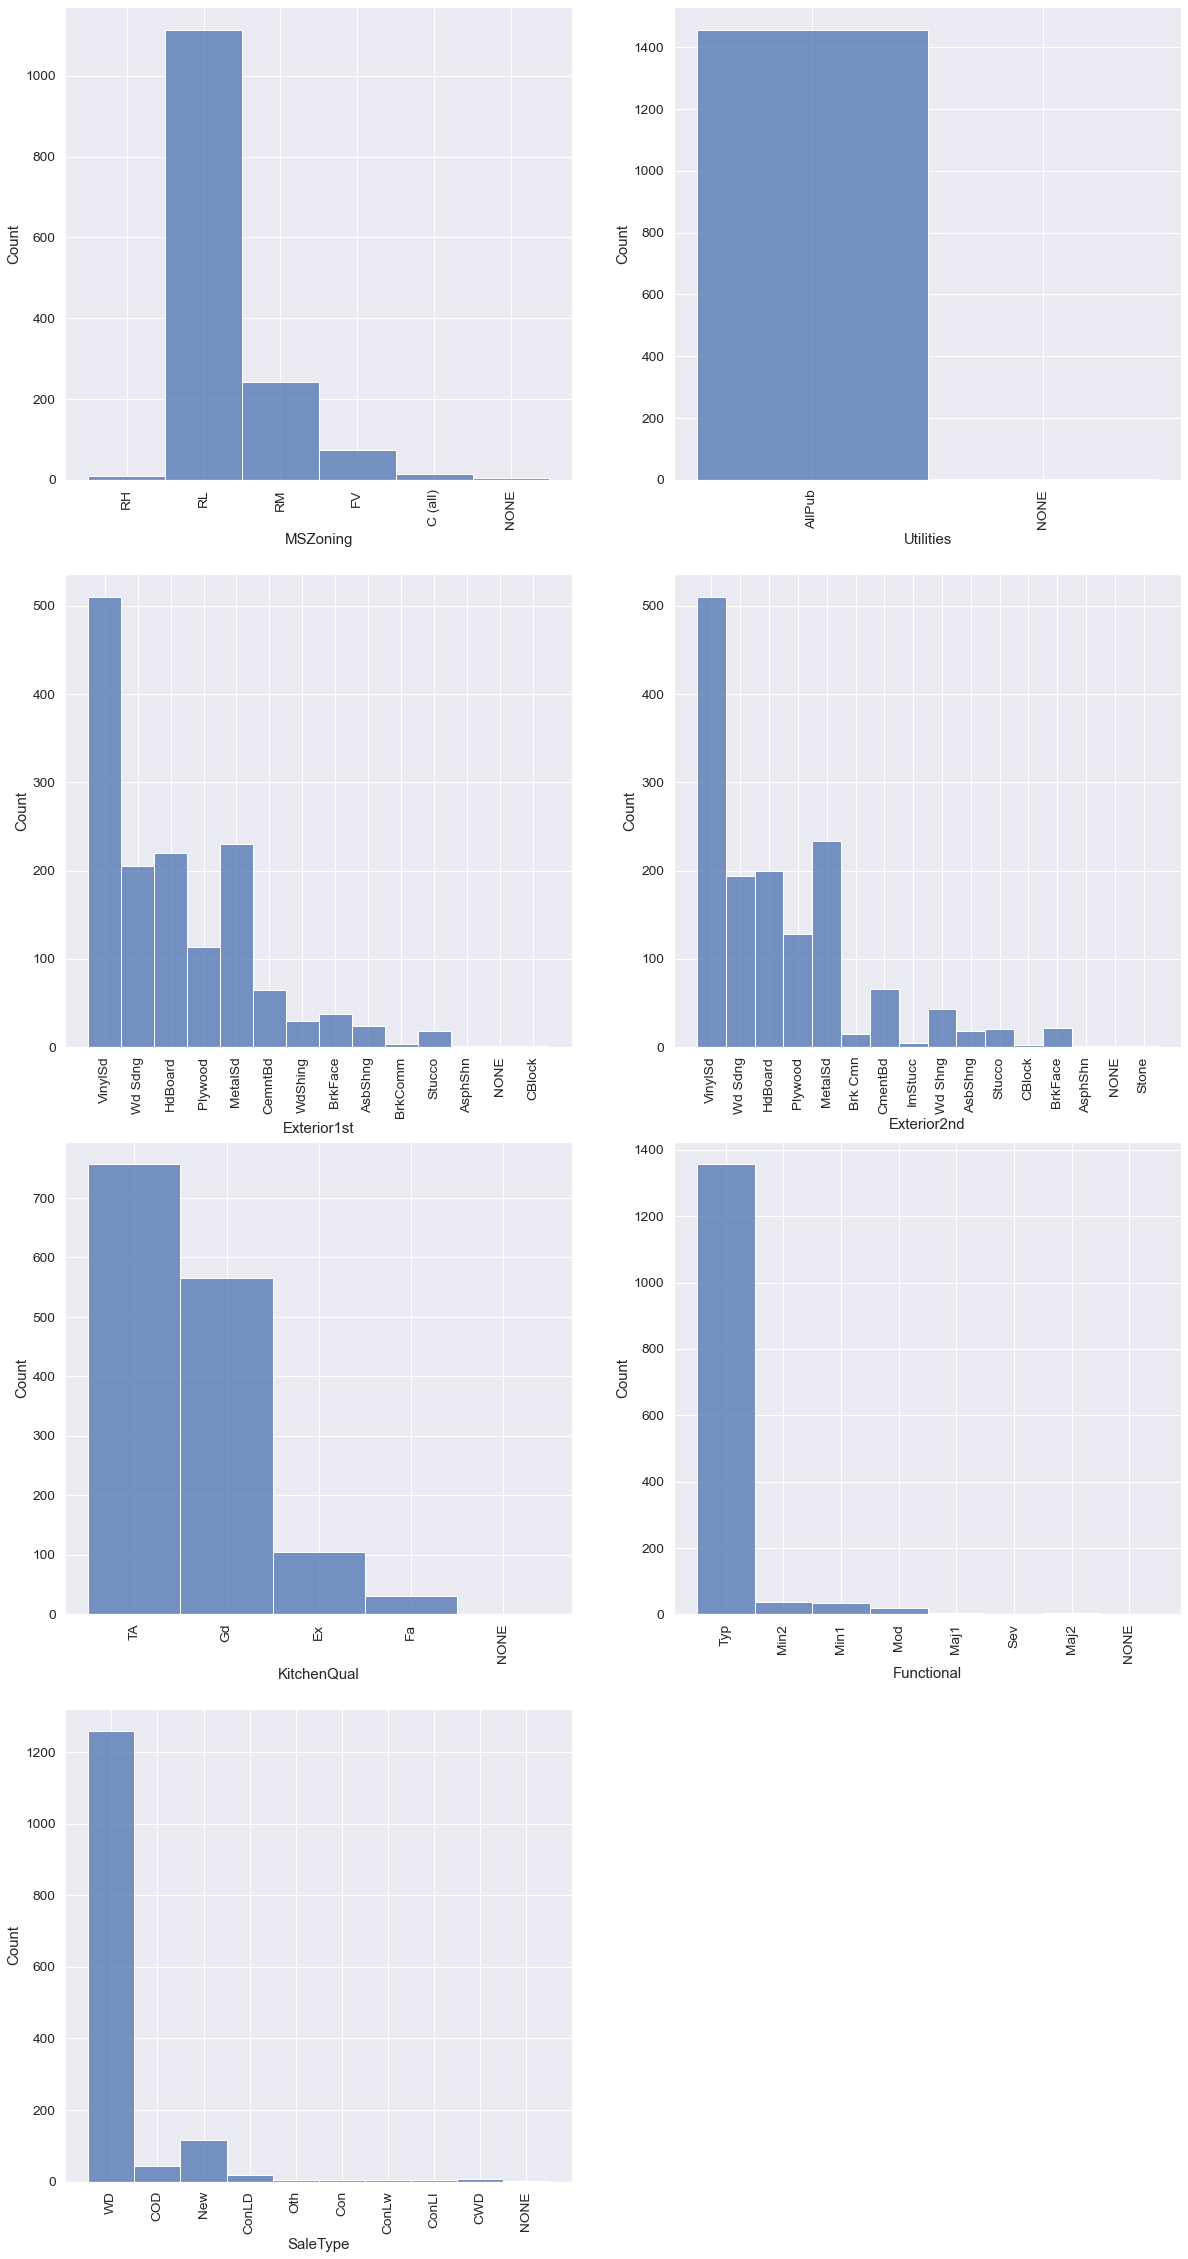

In [24]:
# List of features in both the training and test datasets with NONE
dftl = list(df_none(df_test)['Item'])
dfl = list(df_none(df)['Item'])

plt.figure(figsize=(20,40))
sns.set(font_scale = 1.25)

count = 1

for x in dftl: 
    plt.subplot(4,2,count)
    sns.histplot(data = df_test, x = x)
    plt.xticks(rotation = '90')
    count +=1
plt.show()       

## Because NONE data makes up such a small part of each feature, and because there is typically one predominant attribute for each feature, we will fill the missing NONE values with the mode of each feature

In [25]:
for x in dftl:
    mode = df_test[x].mode().iloc[0]
    df_test[x] = df_test[x].replace('NONE',mode)
    
for x in dfl:
    mode = df[x].mode().iloc[0]
    df[x] = df[x].replace('NONE',mode)

## We will now convert remaining non-numeric features to a categorical type and then to a numerical data feature using label encoding

In [26]:
df_lst = list(df.select_dtypes(include = 'object'))
df_test_lst = list(df_test.select_dtypes(include = 'object'))

df[df_lst] = df[df_lst].astype('category')
df_test[df_test_lst] = df_test[df_test_lst].astype('category')

In [27]:
for x in df_lst:
    df[x] = df[x].cat.codes
for x in df_test_lst:
    df_test[x] = df_test[x].cat.codes

In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   int8   
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   int8   
 5   LotShape       1459 non-null   int8   
 6   LandContour    1459 non-null   int8   
 7   Utilities      1459 non-null   int8   
 8   LotConfig      1459 non-null   int8   
 9   LandSlope      1459 non-null   int8   
 10  Neighborhood   1459 non-null   int8   
 11  Condition1     1459 non-null   int8   
 12  Condition2     1459 non-null   int8   
 13  BldgType       1459 non-null   int8   
 14  HouseStyle     1459 non-null   int8   
 15  OverallQual    1459 non-null   int64  
 16  OverallCond    1459 non-null   int64  
 17  YearBuilt      1459 non-null   int64  
 18  YearRemo

# Time to address missing data in numerical features

In [29]:
def df_numerical_null(x):
    count = len(x.count(axis=1))
    null = pd.DataFrame(x.select_dtypes(exclude = 'category').isnull().sum(), columns = ['Count'])[pd.DataFrame(x.select_dtypes(exclude = 'category').isnull().sum(), columns = ['Count'])['Count']>0]
    null['%_Missing'] = np.round(null/count * 100,1)
    null['Dtype'] = x.dtypes
    null['Item'] = null.index
    return null

In [30]:
df_numerical_null(df)

,Count,%_Missing,Dtype,Item
LotFrontage,255,18.4,float64,LotFrontage
MasVnrArea,7,0.5,float64,MasVnrArea
GarageYrBlt,81,5.8,float64,GarageYrBlt


### LotFrontage footage is missing quite a few rows so we will see if there is a correlation between other attributes to fill data gaps

In [31]:
df.corr()['LotFrontage'].drop('LotFrontage', axis = 0).sort_values(ascending=False)[:10]

LotArea         0.602250
1stFlrSF        0.436923
GrLivArea       0.371243
TotalBsmtSF     0.359486
TotRmsAbvGrd    0.324898
SalePrice       0.314642
GarageArea      0.313227
BedroomAbvGr    0.267272
GarageCars      0.243026
Fireplaces      0.238554
Name: LotFrontage, dtype: float64

> There appears to be relationship between several features so let's fill the gaps with a linear model

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
scaler = MinMaxScaler()

### We will create a temp DF for the model after dropping nulls from our model attributes and the rescale the model X values

In [33]:
df_lf = df[['LotArea', 'LotFrontage', '1stFlrSF', 'GrLivArea']].dropna()

<AxesSubplot:ylabel='LotFrontage'>

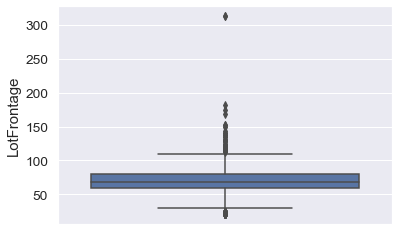

In [34]:
sns.boxplot(data=df_lf, y='LotFrontage')

> There are quite a few outliers so we will drop them from the LotFrontage dataset before modeling

In [35]:
df_lf['LotFrontage'].quantile(.95)

103.45000000000005

In [36]:
df_lf = df_lf[df_lf['LotFrontage']<107.0]

### Let's use a linear regression to fill the LotFrontage gap

In [37]:
X = df_lf[['LotArea', '1stFlrSF', 'GrLivArea']]
y = df_lf['LotFrontage']

In [38]:
X = scaler.fit_transform(X)

In [39]:
lin.fit(X,y)

LinearRegression()

In [40]:
y_pred = lin.predict(X)

In [41]:
print(lin.coef_)
print(lin.intercept_)

[120.32067842  25.5614826   13.20062592]
38.60866347492066


In [42]:
def fill_lot(LotFrontage,LotArea,firstFlrSF,GrLivArea):
    if np.isnan(LotFrontage):
        return lin.coef_[0]*LotArea + lin.coef_[1]*firstFlrSF + lin.coef_[2]*GrLivArea + lin.intercept_
    else:
        return LotFrontage

df['LotFrontage2'] = df.apply(lambda x: fill_lot(x['LotFrontage'], x['LotArea'], x['1stFlrSF'], x['GrLivArea']), axis=1)

In [43]:
df['LotFrontage']=df['LotFrontage2']

In [44]:
df = df.drop('LotFrontage2', axis=1)

### We now need to apply the model to the test dataset to fill the null gaps

In [45]:
def fill_test_lot(LotFrontage,LotArea,firstFlrSF,GrLivArea):
    if np.isnan(LotFrontage):
        return lin.coef_[0]*LotArea + lin.coef_[1]*firstFlrSF + lin.coef_[2]*GrLivArea + lin.intercept_
    else:
        return LotFrontage

df_test['LotFrontage2'] = df_test.apply(lambda x: fill_lot(x['LotFrontage'], x['LotArea'], x['1stFlrSF'], x['GrLivArea']), axis=1)

In [46]:
df_test['LotFrontage']=df_test['LotFrontage2']
df_test = df_test.drop('LotFrontage2', axis=1)

In [47]:
df_numerical_null(df_test)

,Count,%_Missing,Dtype,Item
MasVnrArea,15,1.0,float64,MasVnrArea
BsmtFinSF1,1,0.1,float64,BsmtFinSF1
BsmtFinSF2,1,0.1,float64,BsmtFinSF2
BsmtUnfSF,1,0.1,float64,BsmtUnfSF
TotalBsmtSF,1,0.1,float64,TotalBsmtSF
BsmtFullBath,2,0.1,float64,BsmtFullBath
BsmtHalfBath,2,0.1,float64,BsmtHalfBath
GarageYrBlt,78,5.3,float64,GarageYrBlt
GarageCars,1,0.1,float64,GarageCars
GarageArea,1,0.1,float64,GarageArea


### We will use mode encoding to fill in remaining data gaps since they make up such a small portion of the overall dataset

In [48]:
dfnl = list(df_numerical_null(df)['Item'])
dfntl = list(df_numerical_null(df_test)['Item'])

In [49]:
for x in dfnl:
    mode = df[x].mode().iloc[0]
    df[x] = df[x].fillna(mode)

for x in dfntl:
    mode = df_test[x].mode().iloc[0]
    df_test[x] = df_test[x].fillna(mode)

## Train / Test / Split

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Regressor Models

In [53]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import metrics

In [54]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=4)
rf = RandomForestRegressor(n_estimators=100, max_depth=10)

In [55]:
gb.fit(X_train,y_train)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=10)

In [56]:
gb_predictions = gb.predict(X_test)
rf_predictions = rf.predict(X_test)

In [57]:
print('Gradient Boosting Regressor Metrics')
print('MAE:', metrics.mean_absolute_error(y_test, gb_predictions))
print('MSE:', metrics.mean_squared_error(y_test, gb_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, gb_predictions)))
print('RMSLE:', np.sqrt(metrics.mean_squared_log_error(y_test, gb_predictions)))
print('R2:', metrics.r2_score(y_test, gb_predictions))
print('\n')
print('Random Forest Regressor Metrics')
print('MAE:', metrics.mean_absolute_error(y_test, rf_predictions))
print('MSE:', metrics.mean_squared_error(y_test, rf_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_predictions)))
print('RMSLE:', np.sqrt(metrics.mean_squared_log_error(y_test, rf_predictions)))
print('R2:', metrics.r2_score(y_test, rf_predictions))

Gradient Boosting Regressor Metrics
MAE: 12873.249811707405
MSE: 321246148.6036185
RMSE: 17923.340888450974
RMSLE: 0.1171501386314232
R2: 0.9013170606071335


Random Forest Regressor Metrics
MAE: 14157.370151854013
MSE: 421405711.9071638
RMSE: 20528.168742173857
RMSLE: 0.13428710821501683
R2: 0.8705492516915609


In [58]:
rf_importance = rf.feature_importances_
gb_importance = gb.feature_importances_

In [59]:
rf_importance_df = (pd.Series(rf_importance, index = X_train.columns, name = 'Value').sort_values(ascending=False))
gb_importance_df = (pd.Series(gb_importance, index = X_train.columns, name = 'Value').sort_values(ascending=False))

Text(0.5, 1.0, 'Random Forest Attribute Importance')

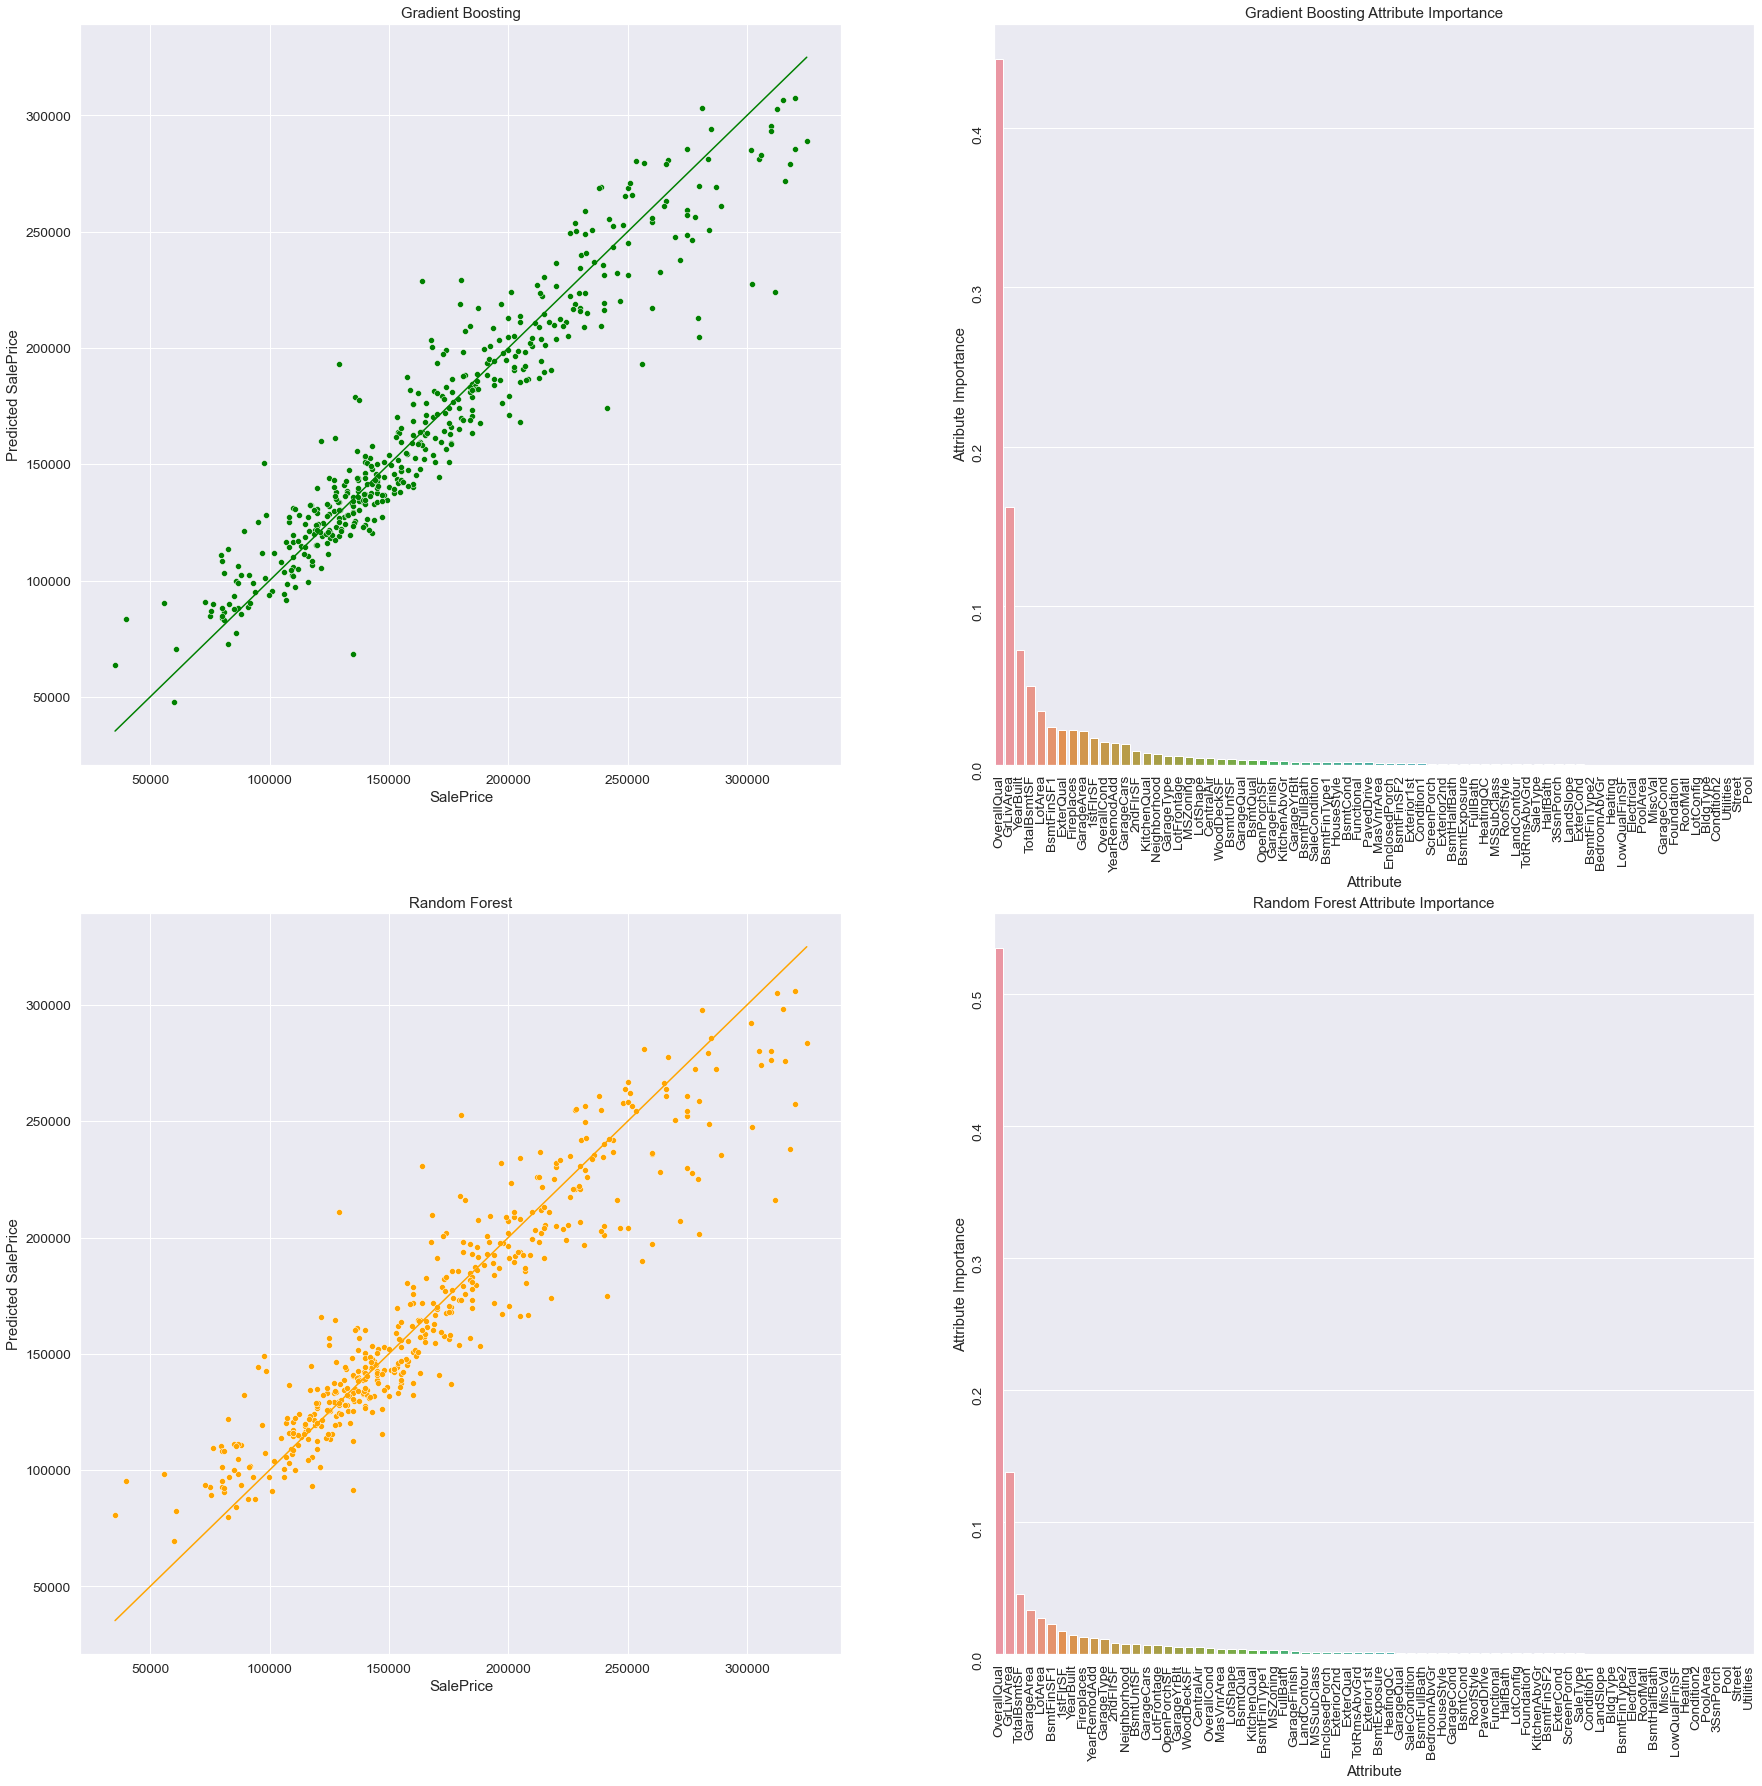

In [60]:
fig, axes = plt.subplots (2,2, figsize=(30,30))

sns.scatterplot(ax = axes[0,0], x = y_test, y = gb_predictions, color = 'green')
sns.lineplot(ax=axes[0,0], x = y_test, y = y_test, color = 'green')
axes[0,0].set_xlabel("SalePrice")
axes[0,0].set_ylabel("Predicted SalePrice")
axes[0,0].set_title('Gradient Boosting')

sns.barplot(ax = axes[0,1], x = gb_importance_df.index, y = gb_importance_df)
axes[0,1].tick_params(labelrotation=90)
axes[0,1].set_xlabel("Attribute")
axes[0,1].set_ylabel("Attribute Importance")
axes[0,1].set_title('Gradient Boosting Attribute Importance')

sns.scatterplot(ax = axes[1,0], x = y_test, y = rf_predictions, color = 'orange')
sns.lineplot(ax=axes[1,0], x = y_test, y = y_test, color = 'orange')
axes[1,0].set_xlabel("SalePrice")
axes[1,0].set_ylabel("Predicted SalePrice")
axes[1,0].set_title('Random Forest')

sns.barplot(ax=axes[1,1], x = rf_importance_df.index, y = rf_importance_df)
axes[1,1].tick_params(labelrotation=90)
axes[1,1].set_xlabel("Attribute")
axes[1,1].set_ylabel("Attribute Importance")
axes[1,1].set_title('Random Forest Attribute Importance')

> To simplify the model, it is quite possible that we can achieve smiliar results with fewer features

In [61]:
rf_short_list = list(rf_importance_df.sort_values(ascending = False)[0:15].index)
gb_short_list = list(gb_importance_df.sort_values(ascending = False)[0:15].index)

In [62]:
X_train_rfs = X_train[rf_short_list]
X_test_rfs = X_test[rf_short_list]

X_train_gbs = X_train[gb_short_list]
X_test_gbs = X_test[gb_short_list]

In [63]:
gbs = GradientBoostingRegressor(n_estimators=100, max_depth=4)
rfs = RandomForestRegressor(n_estimators=100, max_depth=10)

In [64]:
rfs.fit(X_train_rfs,y_train)
gbs.fit(X_train_gbs,y_train)

GradientBoostingRegressor(max_depth=4)

In [65]:
rfs_predictions = rfs.predict(X_test_rfs)
gbs_predictions = gbs.predict(X_test_gbs)

In [66]:
print('Random Forest Regressor Metrics')
print('MAE:', metrics.mean_absolute_error(y_test, rfs_predictions))
print('MSE:', metrics.mean_squared_error(y_test, rfs_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfs_predictions)))
print('RMSLE:', np.sqrt(metrics.mean_squared_log_error(y_test, rfs_predictions)))
print('R2:', metrics.r2_score(y_test, rfs_predictions))
print('\n')
print('Gradient Boost Metrics')
print('MAE:', metrics.mean_absolute_error(y_test, gbs_predictions))
print('MSE:', metrics.mean_squared_error(y_test, gbs_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, gbs_predictions)))
print('RMSLE:', np.sqrt(metrics.mean_squared_log_error(y_test, gbs_predictions)))
print('R2:', metrics.r2_score(y_test, gbs_predictions))

Random Forest Regressor Metrics
MAE: 15037.526871843032
MSE: 448303505.32604074
RMSE: 21173.17891404219
RMSLE: 0.13972193611918135
R2: 0.8622865742110846


Gradient Boost Metrics
MAE: 13425.660656602115
MSE: 362420881.9638636
RMSE: 19037.35490985719
RMSLE: 0.12504726862924995
R2: 0.8886686795000961


> We can achieve simiarl predictive results by reducing the feature variables from 72 to 15.  This makes for a much less complex and efficient model

In [67]:
rfs_importance = rfs.feature_importances_
gbs_importance = gbs.feature_importances_

Text(0.5, 1.0, 'Random Forest Attribute Importance')

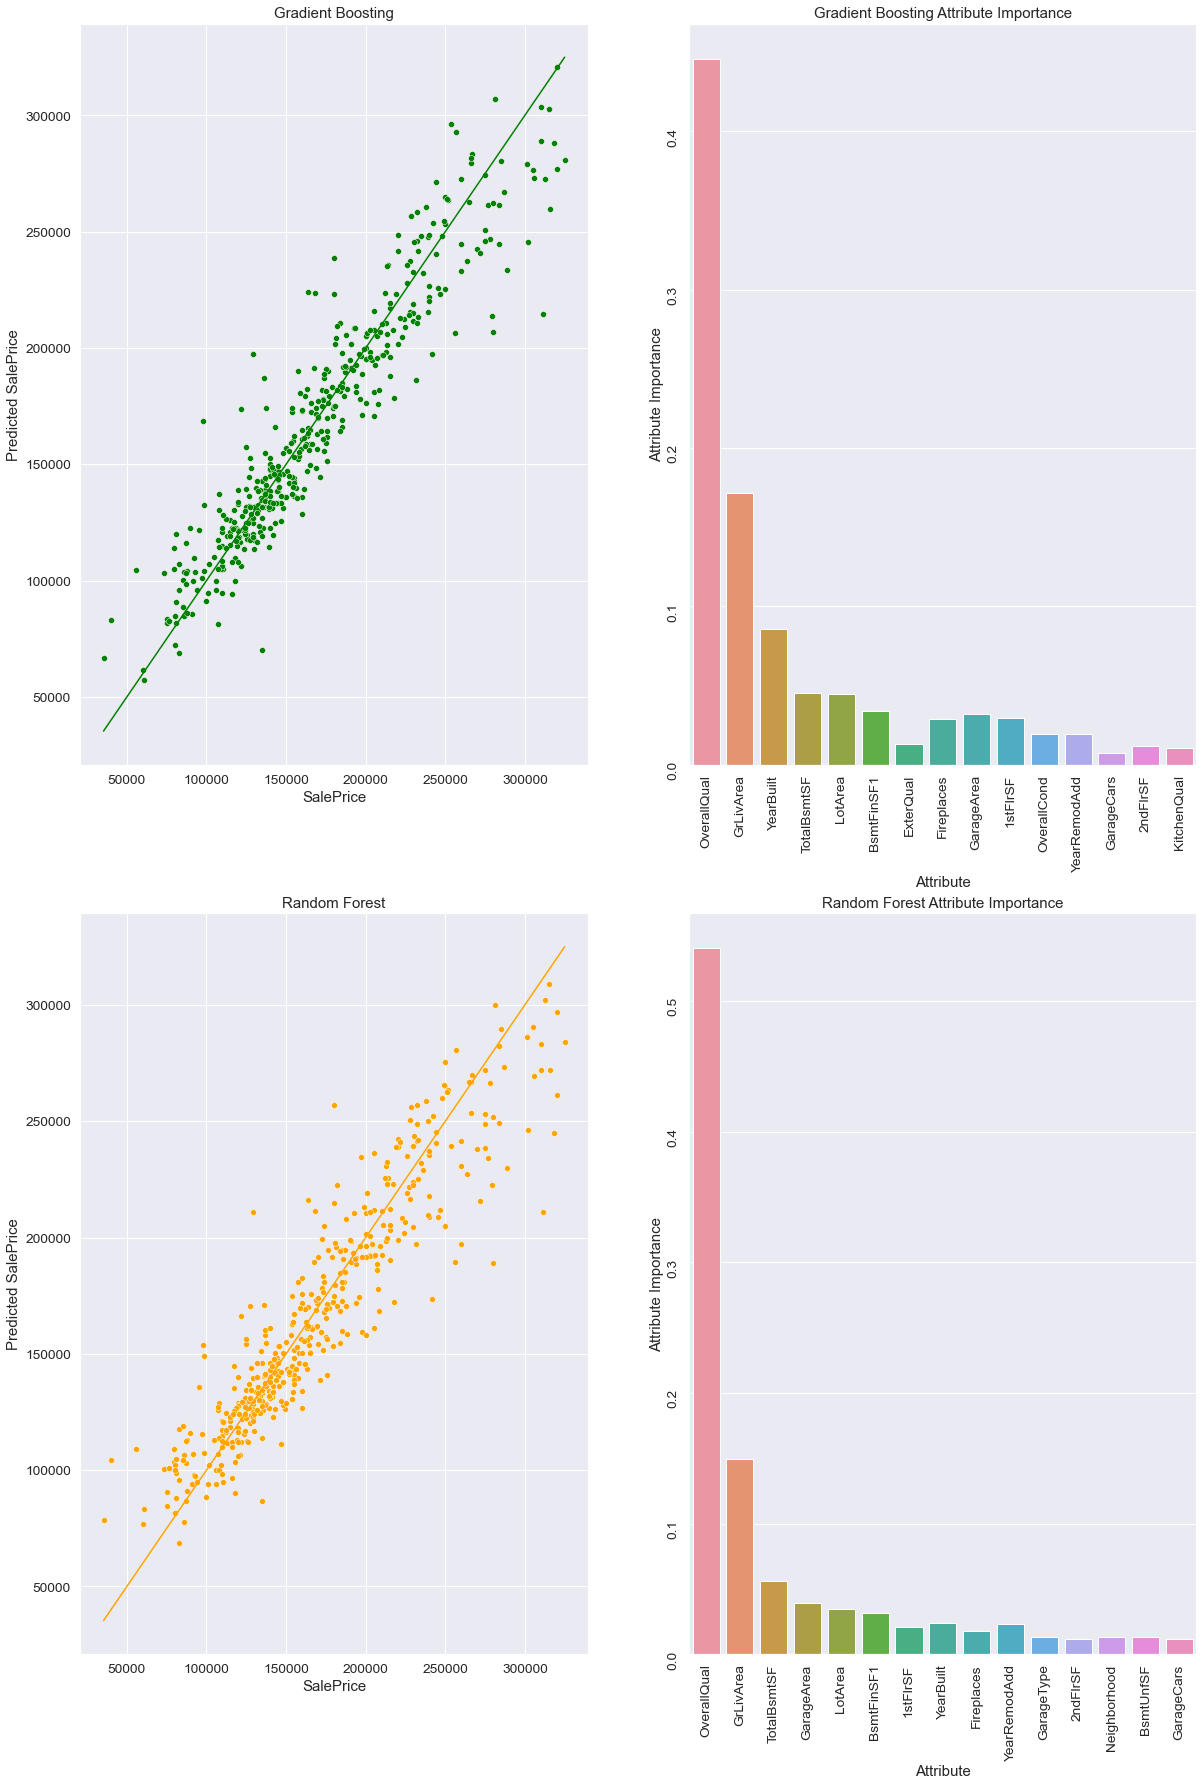

In [68]:
fig, axes = plt.subplots (2,2, figsize=(20,30))

sns.scatterplot(ax = axes[0,0], x = y_test, y = gbs_predictions, color = 'green')
sns.lineplot(ax=axes[0,0], x = y_test, y = y_test, color = 'green')
axes[0,0].set_xlabel("SalePrice")
axes[0,0].set_ylabel("Predicted SalePrice")
axes[0,0].set_title('Gradient Boosting')

sns.barplot(ax = axes[0,1], x = X_train_gbs.columns, y = gbs_importance)
axes[0,1].tick_params(labelrotation=90)
axes[0,1].set_xlabel("Attribute")
axes[0,1].set_ylabel("Attribute Importance")
axes[0,1].set_title('Gradient Boosting Attribute Importance')

sns.scatterplot(ax = axes[1,0], x = y_test, y = rfs_predictions, color = 'orange')
sns.lineplot(ax=axes[1,0], x = y_test, y = y_test, color = 'orange')
axes[1,0].set_xlabel("SalePrice")
axes[1,0].set_ylabel("Predicted SalePrice")
axes[1,0].set_title('Random Forest')

sns.barplot(ax=axes[1,1], x = X_train_rfs.columns, y = rfs_importance)
axes[1,1].tick_params(labelrotation=90)
axes[1,1].set_xlabel("Attribute")
axes[1,1].set_ylabel("Attribute Importance")
axes[1,1].set_title('Random Forest Attribute Importance')

### We can now use the SHAP library to better illustrate the relationship of each feature to the target variable (Sale Price)

In [69]:
gbs_shap = shap.TreeExplainer(gbs).shap_values(X_train_gbs)
gbs_shapdf = pd.DataFrame(gbs_shap, columns =X_train_gbs.columns)

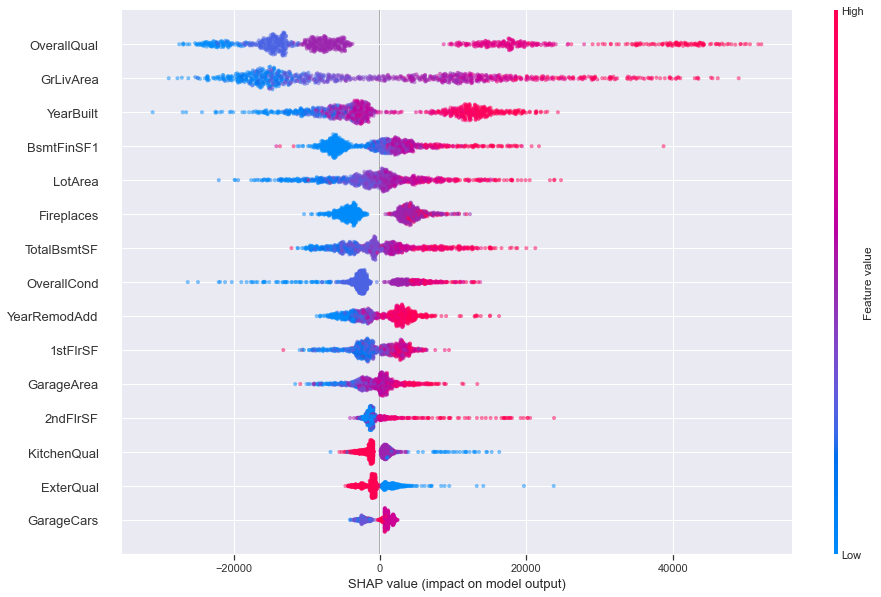

In [70]:
shap.summary_plot(gbs_shap, X_train_gbs, plot_size=(15,10), alpha = 0.5)

> The shapley tornando chart illustrates the degree and direction (positive or negatice) of influence

### We can also utilize the SHAP dependence plots to illustrate how each key feature influences SalePrice.  The Y-axis at 0 suggests an average SalePrice for each feature based on the model input as a whole.  Positive Y values indicate an above average SalePrice and negative Y values indicate below average SalePrice.  As you can see, several of these features have a non-linear relationship

#### For example, a home with ~1,500 sqft above grade living area (GrLivArea) equates to an average SalePrice.  Homes with more sqft have a higher sales price and homes with less sqft degrade in SalePrice

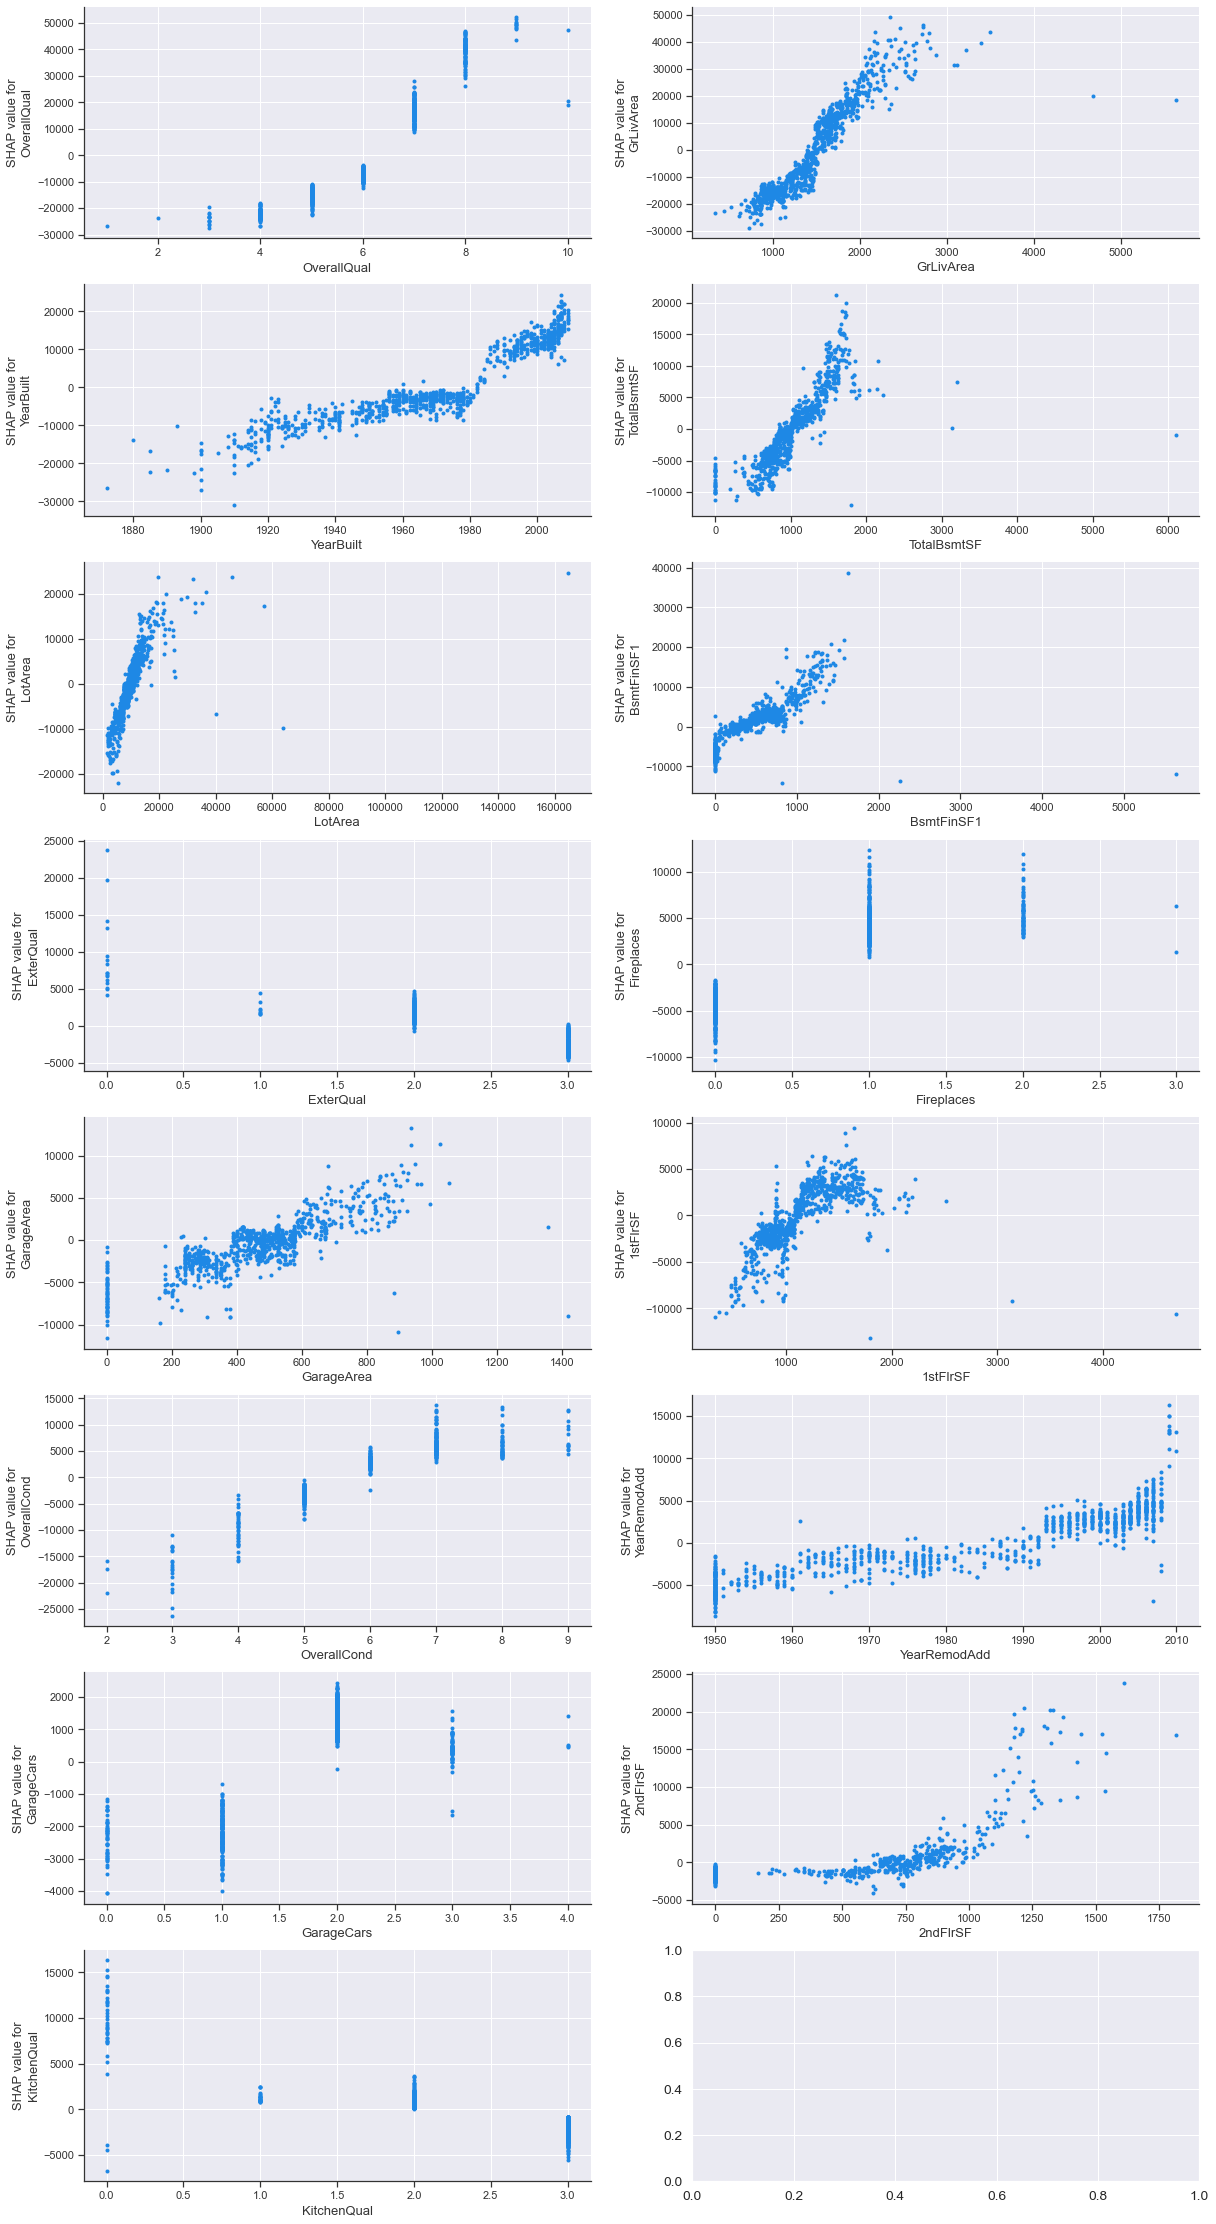

In [71]:
features = X_train_gbs.columns

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 40))
axes = axes.ravel()

for i, col in enumerate(features):
    shap.dependence_plot(col, gbs_shap, X_train_gbs, interaction_index=None, ax=axes[i], show=False)

### We will now apply our simplified GBS model to the true test dataset in the Test DataFrame

In [72]:
# First, let's limit the test dataframe to only those features necessary to prediect SalePrice based on our final model
df_test = df_test[features]

In [73]:
# We then apply the predictive model the test dataset
gbs_test_predictions = gbs.predict(df_test)